In [1]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
import scipy
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi

import timeit

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('/home/chen/ar40/config/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']

In [4]:
#Good events for run_0102 are: 689, 765, 896, 305, 504, 575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485, 2456, 357, 4568, 1448, 6587, 3578, 745, 430
full = h5py.File('/home/chen/ar40/config/clean_run_0102.h5', 'r')
evt_ID = 504

dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]

xyzs = np.array(xyzs_h5)

#delete the points which are farther away from the center of the spiral
del_list = []

for i in range(len(xyzs)):
    if (xyzs[i,6]) > 150.0:
        del_list.append(i)
cut_xyzs = np.delete(xyzs,del_list,axis=0)

print(len(evt_full))

69631


In [5]:
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)

cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

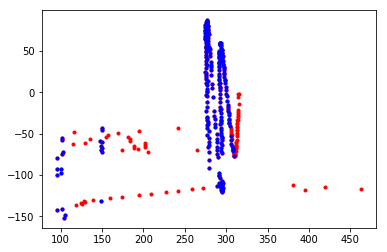

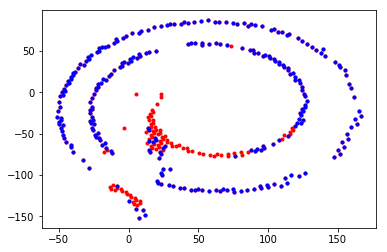

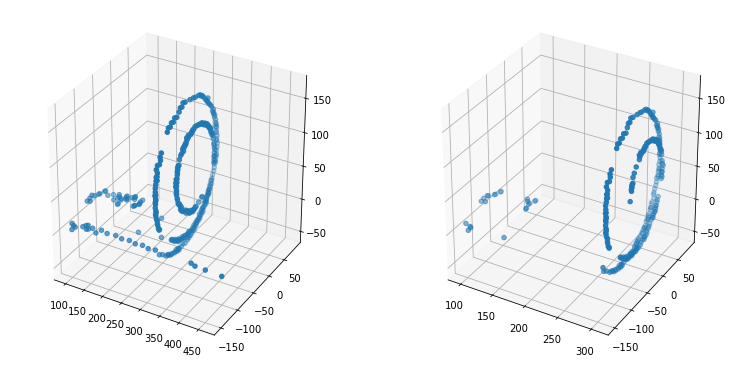

In [6]:
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0])
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0])

<IPython.core.display.Javascript object>


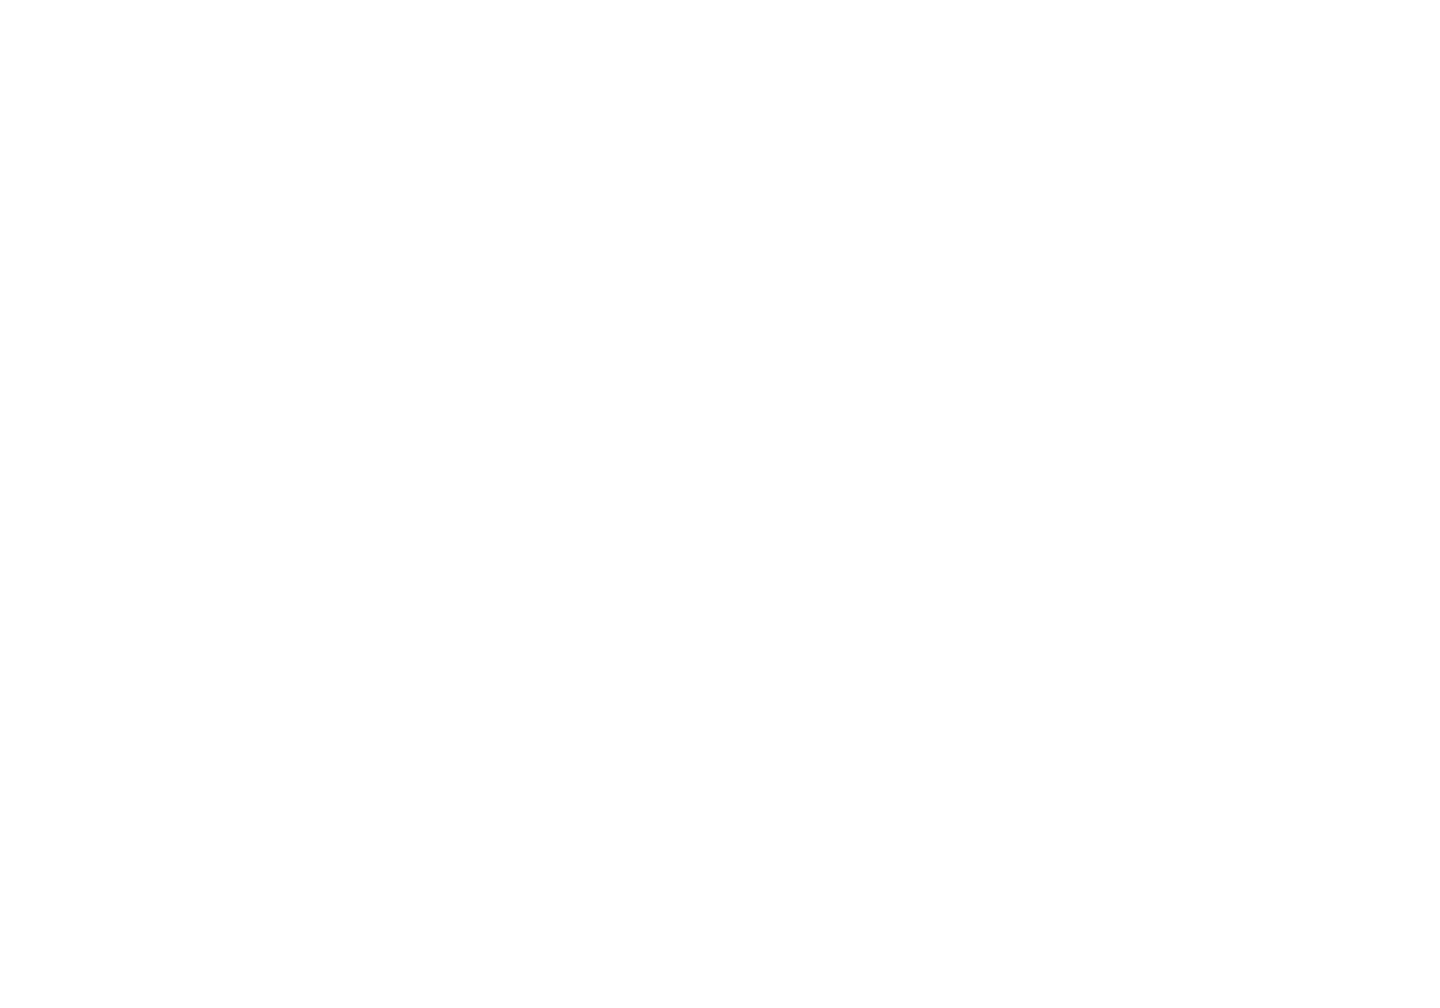

<IPython.core.display.Javascript object>


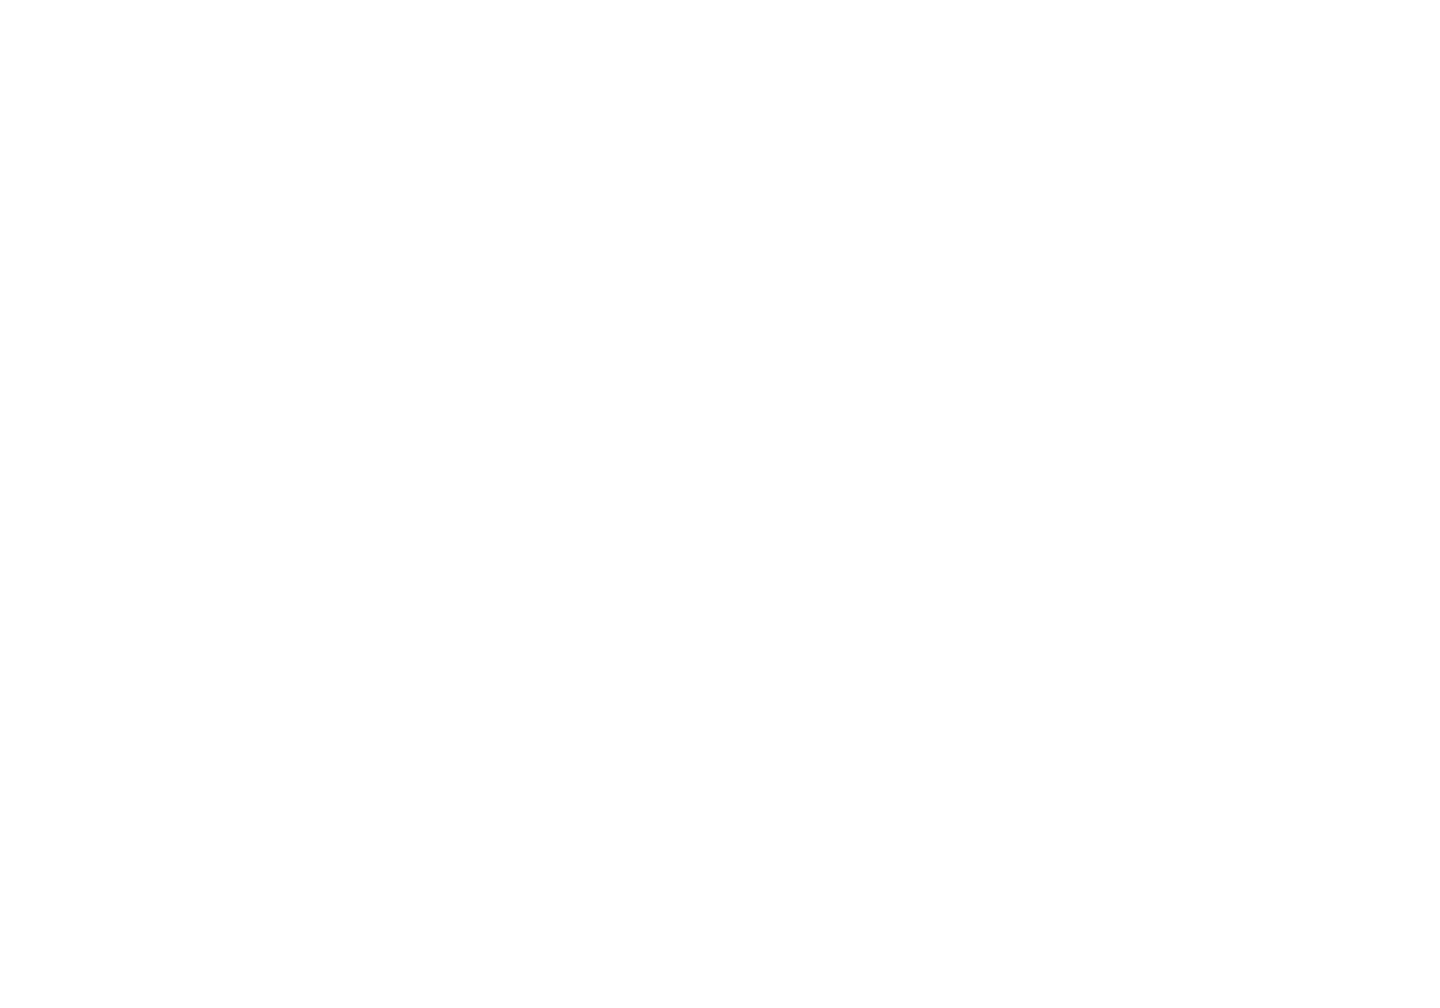

In [57]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0], c='r', label='original data')
ax.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0], c='b', label='after cut')


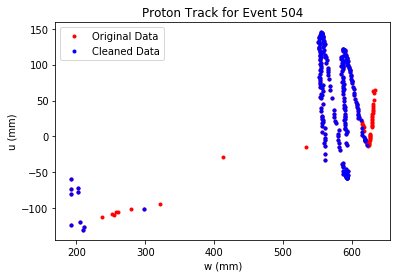

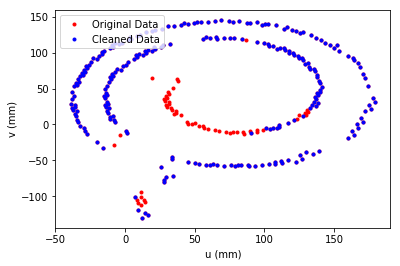

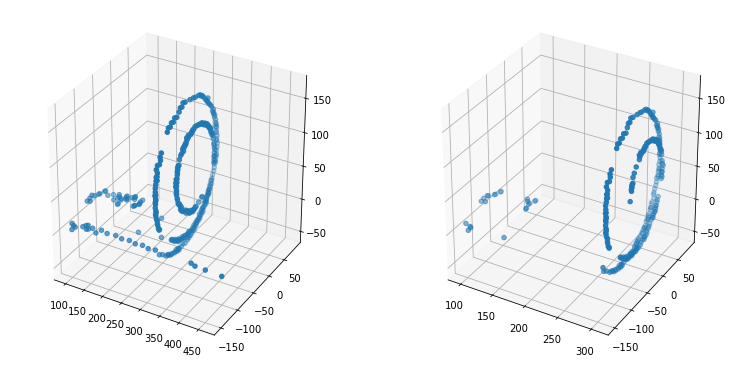

In [31]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
uvw_values = uvw.values

cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
cut_uvw_values = cut_uvw.values

%matplotlib inline
plt.plot(uvw_values[:, 2], uvw_values[:, 1], 'r.', label='Original Data')
plt.plot(cut_uvw_values[:, 2], cut_uvw_values[:, 1], 'b.', label='Cleaned Data')
plt.legend(loc=2)
plt.xlabel('w (mm)')
plt.ylabel("u (mm)")
plt.title("Proton Track for Event 504")
plt.show()
plt.plot(uvw_values[:, 0], uvw_values[:, 1], 'r.', label='Original Data')
plt.plot(cut_uvw_values[:, 0], cut_uvw_values[:, 1], 'b.', label='Cleaned Data')
plt.xlabel("u (mm)")
plt.ylabel("v (mm)")
plt.legend(loc=2)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0])
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0])

In [8]:
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

In [9]:
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
cut_exp_hits = np.zeros(10240)
for a, p in cut_uvw[['a', 'pad']].values:
    cut_exp_hits[int(p)] = a

In [10]:
minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)

Conjugate Gradient

In [11]:
def f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def jacobian(x):
    return scipy.optimize.approx_fprime(x,f,eps)


In [12]:
def cut_f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, cut_exp_pos, cut_exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def cut_jacobian(x):
    return scipy.optimize.approx_fprime(x,cut_f,eps)

In [41]:
i = 1
def callbackF(x):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1   
     

In [42]:
results = scipy.optimize.minimize(f, ctr0, method="CG", jac=jacobian, callback=callbackF, options={'gtol': 30.0, 'eps':eps})    
cg = results.x
print(results)

   1-0.000191 0.000453 0.366927 0.860407-2.730986 1.325476 106.983801
     fun: 106.98380108994674
     jac: array([-26.73066425, -26.37411785,  -3.10607529,   0.68884945,
         2.57320023,   8.80958462])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 1
    njev: 5
  status: 0
 success: True
       x: array([-1.90651021e-04,  4.52543296e-04,  3.66927236e-01,  8.60407081e-01,
       -2.73098588e+00,  1.32547608e+00])


In [43]:
j = 1    
def cut_callbackF(x):
    global j
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],cut_f(x)))
    j += 1  

In [ ]:
cut_results = scipy.optimize.minimize(cut_f, cut_ctr0, method="CG", jac=cut_jacobian, callback=cut_callbackF, options={'gtol': 30.0, 'eps':1e-13})    
cut_cg = cut_results.x
print(cut_results)

In [ ]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(cg[0], cg[1], cg[2], cg[3], cg[4], cg[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values


In [ ]:
cut_evtClean, cut_ctr = sim.make_event(cut_cg[0], cut_cg[1], cut_cg[2], cut_cg[3], cut_cg[4], cut_cg[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values


In [ ]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5],c='r')
ax.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5],c='b')
ax.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5],c='g')


In [ ]:
scipy.optimize.fmin_bfgs(cut_f, cut_ctr0, fprime=cut_jacobian, callback=cut_callbackF)

Differential Evolution

In [20]:
i = 1
def callbackF(x, convergence=10):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1
bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]

In [21]:
%%time
results = scipy.optimize.differential_evolution(f, bounds, callback=callbackF, maxiter=1000, strategy='best1bin',\
                                                recombination=0.7, popsize=25, mutation=(0.5,1.5))
'''    The differential evolution strategy should be one of:
            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result
            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result
            ‘rand1exp’ - takes a long time but converges
            ‘randtobest1exp’ - takes a long time but converges
            ‘currenttobest1exp’ - takes a long time but converges
            ‘best2exp’
            ‘rand2exp’
            ‘randtobest1bin’
            ‘currenttobest1bin’
            ‘best2bin’
            ‘rand2bin’
            ‘rand1bin’
    The default is ‘best1bin’.
'''

   1-0.035870 0.024389 0.828209 1.285486-0.644452 3.502642 129.823698
   2-0.000469-0.017344 0.696201 2.586952-2.373830-2.154276 100.820268
   3-0.000469-0.017344 0.696201 2.586952-2.373830-2.154276 100.820268
   4-0.000469-0.017344 0.696201 2.586952-2.373830-2.154276 100.820268
   5-0.000469-0.017344 0.696201 2.586952-2.373830-2.154276 100.820268
   6-0.000469-0.017344 0.696201 2.586952-2.373830-2.154276 100.820268
   7-0.000469-0.017344 0.696201 2.586952-2.373830-2.154276 100.820268
   8-0.000469-0.017344 0.696201 2.586952-2.373830-2.154276 100.820268
   9-0.005474-0.001462 0.832589 1.946878 3.945566-3.026173 96.831772
  10-0.005474-0.001462 0.832589 1.946878 3.945566-3.026173 96.831772
  11-0.005474-0.001462 0.832589 1.946878 3.945566-3.026173 96.831772
  12 0.006444 0.003442 0.568975 4.538583 5.155926-1.318546 94.545202
  13 0.010582 0.003133 0.829005 2.748970 6.219589 3.471527 92.546474
  14-0.004514 0.002977 0.825584 2.726807 2.728144-3.787861 90.279803
  15-0.004514 0.002977 0.8

 120 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 121 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 122 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 123 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 124 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 125 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 126 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 127 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 128 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 129 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 130 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 131 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 132 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 133 0.009916 0.005073 0.542217 1.757136 5.589270-1.498655 77.110466
 134 0.009916 0.005073 0.542217 1.

 239 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 240 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 241 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 242 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 243 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 244 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 245 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 246 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 247 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 248 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 249 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 250 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 251 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 252 0.001332 0.005972 0.542217 1.757136 5.589270-1.498655 74.417927
 253 0.001332 0.005972 0.542217 1.

 358 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 359 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 360 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 361 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 362 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 363 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 364 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 365 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 366 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 367 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 368 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 369 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 370 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 371 0.002858-0.005030 0.552747 2.171558 5.553670-1.523701 58.169643
 372 0.002858-0.005030 0.552747 2.

 477 0.001338-0.008248 0.552747 2.171558 5.553670-1.523701 57.156450
 478 0.001338-0.008248 0.552747 2.171558 5.553670-1.523701 57.156450
 479-0.003168-0.009441 0.553390 2.077652 5.533195-1.522714 56.610363
 480-0.003168-0.009441 0.553390 2.077652 5.533195-1.522714 56.610363
 481-0.003168-0.009441 0.553390 2.077652 5.533195-1.522714 56.610363
 482-0.003168-0.009441 0.553390 2.077652 5.533195-1.522714 56.610363
 483 0.001708-0.006065 0.552931 2.033385 5.555584-1.521501 55.533927
 484 0.001708-0.006065 0.552931 2.033385 5.555584-1.521501 55.533927
 485 0.001708-0.006065 0.552931 2.033385 5.555584-1.521501 55.533927
 486 0.001708-0.006065 0.552931 2.033385 5.555584-1.521501 55.533927
 487 0.001708-0.006065 0.552931 2.033385 5.555584-1.521501 55.533927
 488 0.001708-0.006065 0.552931 2.033385 5.555584-1.521501 55.533927
 489-0.003723-0.005666 0.551779 1.938908 5.616275-1.517574 55.165730
 490-0.003163-0.003301 0.550906 2.017340 5.595206-1.517774 55.000508
 491-0.003163-0.003301 0.550906 2.

In [22]:
results.fun #30.26455552871073 

53.029014920500764

In [23]:
dfe = results.x
print(dfe)
#evt_299:[ 7.84428822e-03  3.53398504e-03  9.23208704e-01  2.58491529e+00 -9.73837034e-01 -4.45947600e+00]
#evt_399: [ 0.00773186  0.01781402  0.8011877   3.11712508 -0.46023263 -4.4246107 ]


[-3.88478859e-03 -3.42033576e-03  5.52074198e-01  1.99168161e+00
  5.56165321e+00 -1.51928493e+00]


In [24]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(dfe[0], dfe[1], dfe[2], dfe[3], dfe[4], dfe[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [25]:
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

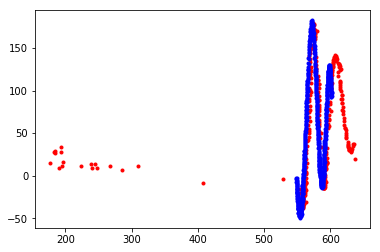

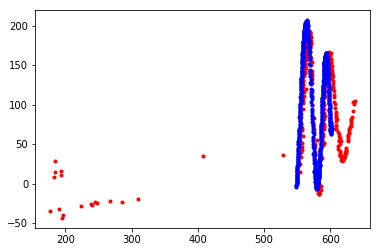

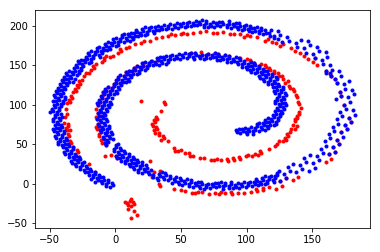

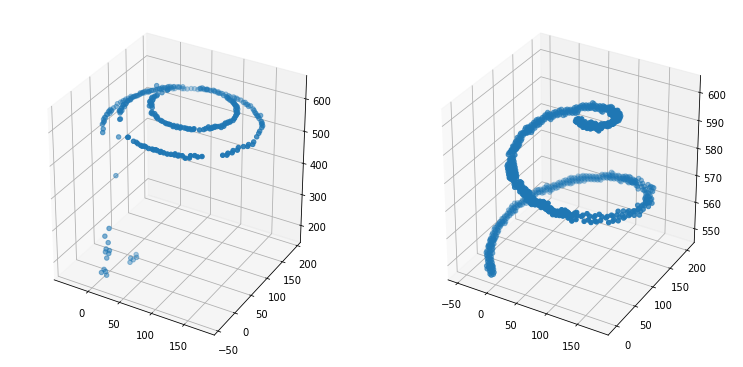

In [26]:
%matplotlib inline
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,5],uvw_values[:,6],uvw_values[:,7])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,5],sim_uvw_values[:,6],sim_uvw_values[:,7])

<IPython.core.display.Javascript object>


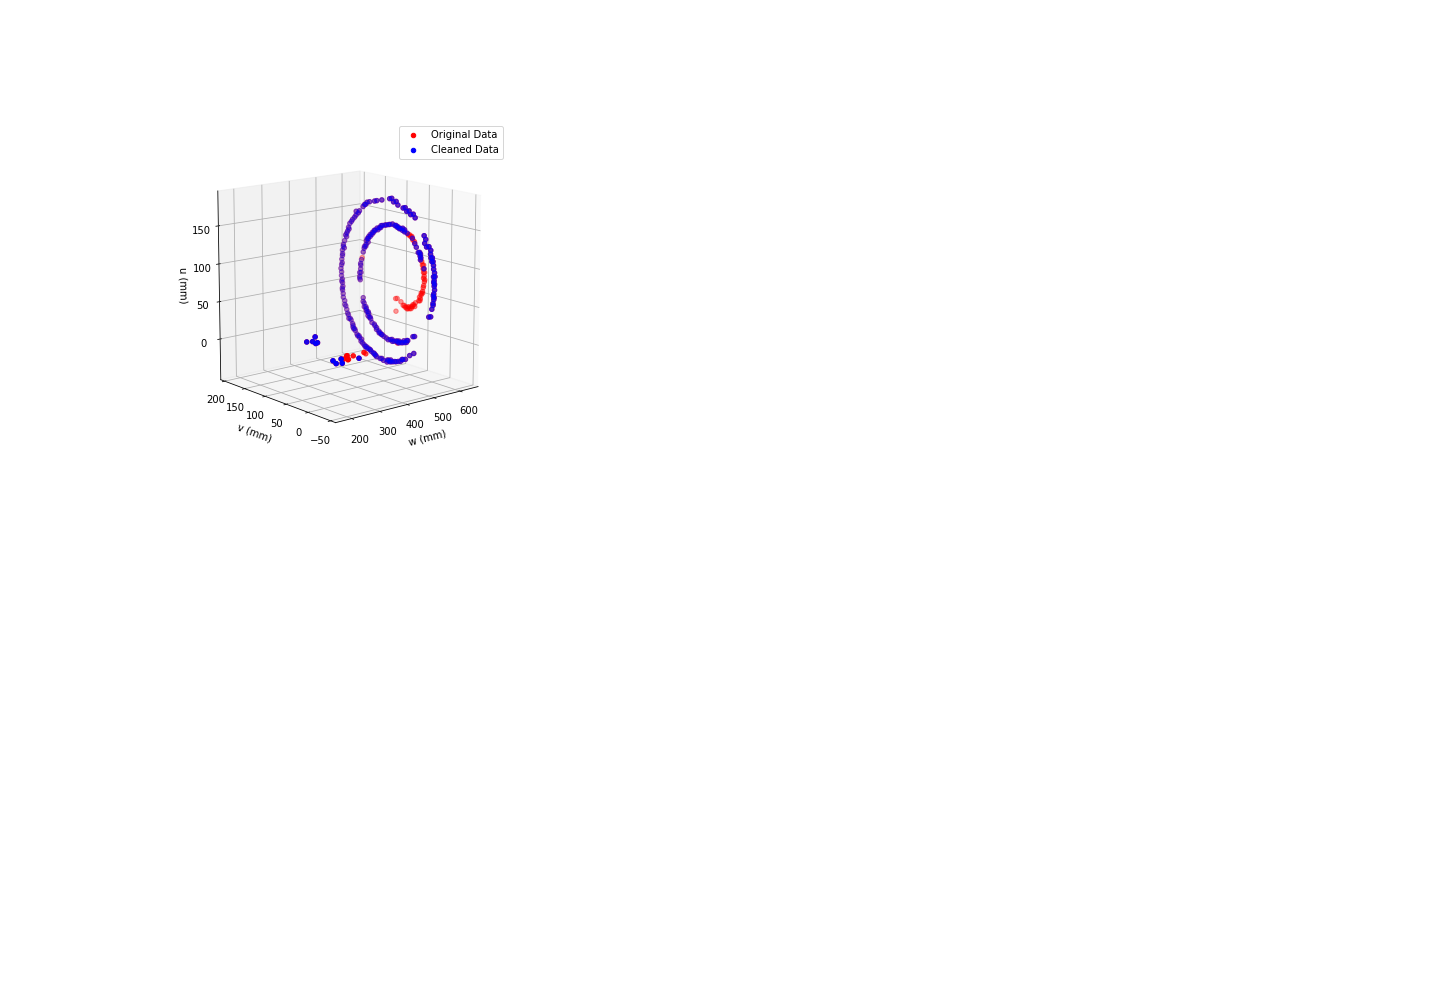

Text(0.5,0,'u (mm)')

In [50]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5],c='r',label='Original Data')
ax.scatter(cut_uvw_values[:,7],cut_uvw_values[:,6],cut_uvw_values[:,5],c='b', label='Cleaned Data')
ax.legend()
ax.set_xlabel('w (mm)')
ax.set_ylabel("v (mm)")
ax.set_zlabel("u (mm)")
#ax.set_title("Proton Track for Event 504")

In [34]:

i = 1
def cut_callbackF(x, convergence=10):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],cut_f(x)))
    i += 1
bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]


   1 0.104354-0.075532 0.923835 2.931151-2.307527-3.042474 432.680934
   2 0.045640 0.061615 0.761589 2.137093-2.515596-2.898421 215.176305
   3 0.045640 0.061615 0.761589 2.137093-2.515596-2.898421 215.176305
   4 0.024884-0.027365 0.482281 1.533797 0.416190 5.136145 128.142435
   5-0.010448 0.008416 0.362623 1.756783 3.258326 1.764330 104.394264
   6-0.010448 0.008416 0.362623 1.756783 3.258326 1.764330 104.394264
   7-0.010448 0.008416 0.362623 1.756783 3.258326 1.764330 104.394264
   8-0.010448 0.008416 0.362623 1.756783 3.258326 1.764330 104.394264
   9-0.002266 0.001135 0.872826 3.403311-1.749152 0.825141 100.906522
  10 0.014621-0.017786 0.764227 2.107307 5.035669 4.074833 100.725223
  11 0.014621-0.017786 0.764227 2.107307 5.035669 4.074833 100.725223
  12-0.000329 0.001575 0.289437 4.112341-5.683845 2.836119 98.590714
  13 0.004017-0.007039 0.161009 4.157940 1.552616 0.186902 94.956909
  14-0.008119-0.010662 0.768230 3.432313-1.952344-2.285352 94.034128
  15-0.008119-0.010662 

 120 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 121 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 122 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 123 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 124 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 125 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 126 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 127 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 128 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 129 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 130 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 131 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 132 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 133 0.002486-0.002079 0.533113 3.925699-3.827654 1.518931 83.723115
 134 0.002486-0.002079 0.533113 3.

 239 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 240 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 241 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 242 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 243 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 244 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 245 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 246 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 247 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 248 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 249 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 250 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 251 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 252 0.004940 0.009422 0.533113 3.925699-4.037112 1.518931 81.468894
 253 0.004940 0.009422 0.533113 3.

In [ ]:
%%time
results = scipy.optimize.differential_evolution(cut_f, bounds, callback=cut_callbackF, maxiter=1000, strategy='best1bin',\
                                                 recombination=0.7, popsize=15, mutation=(0.5,1.5))
'''    The differential evolution strategy should be one of:
            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result
            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result
            ‘rand1exp’ - takes a long time but converges
            ‘randtobest1exp’ - takes a long time but converges
            ‘currenttobest1exp’ - takes a long time but converges
            ‘best2exp’
            ‘rand2exp’
            ‘randtobest1bin’
            ‘currenttobest1bin’
            ‘best2bin’
            ‘rand2bin’
            ‘rand1bin’
    The default is ‘best1bin’.
'''

In [35]:
cut_dfe = results.x

In [36]:
cut_evtClean, cut_ctr = sim.make_event(cut_dfe[0], cut_dfe[1], cut_dfe[2], cut_dfe[3], cut_dfe[4], cut_dfe[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [37]:
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

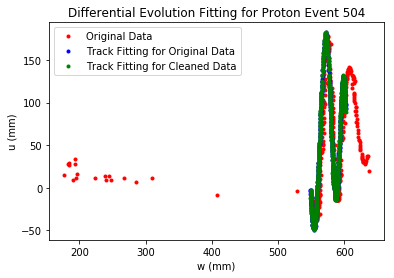

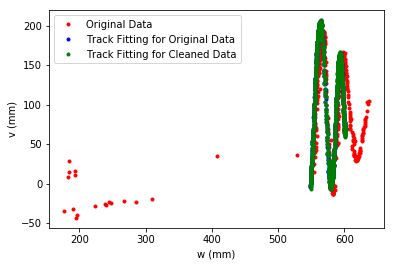

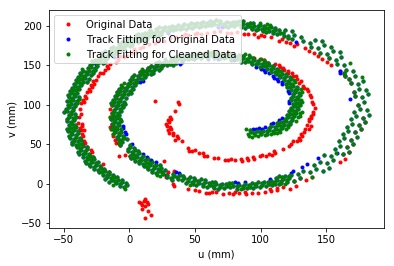

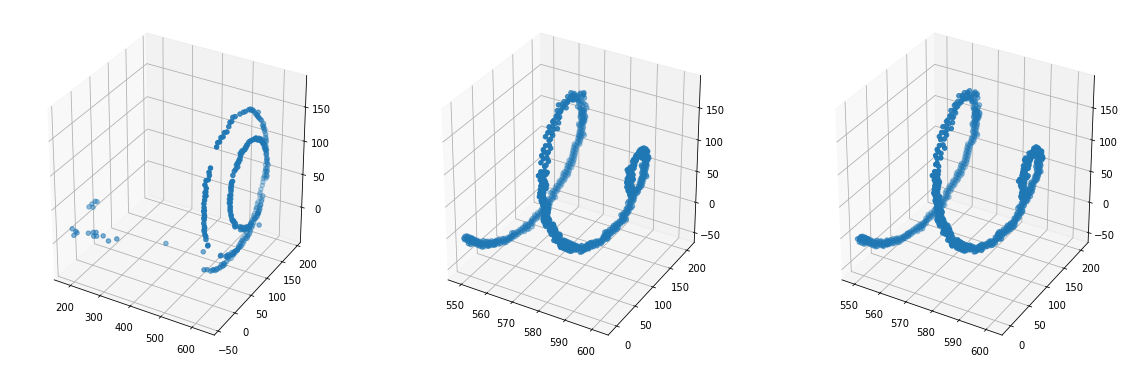

In [51]:
%matplotlib inline
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Original Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Track Fitting for Original Data')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label="Track Fitting for Cleaned Data")
plt.xlabel("w (mm)")
plt.ylabel("u (mm)")
plt.title("Differential Evolution Fitting for Proton Event 504")
plt.legend(loc=2)
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Original Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Track Fitting for Original Data')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label="Track Fitting for Cleaned Data")
plt.xlabel("w (mm)")
plt.ylabel("v (mm)")
plt.legend(loc=2)
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Original Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.', label='Track Fitting for Original Data')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label="Track Fitting for Cleaned Data")
plt.xlabel("u (mm)")
plt.ylabel("v (mm)")
plt.legend(loc=2)
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])



In [ ]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5],c='r')
ax.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5],c='b')
ax.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5],c='g')

In [52]:
i = 1
def callbackF(x, f, accept):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f))
    i += 1

In [53]:
%%time
bh_nm_results = scipy.optimize.basinhopping(f,ctr0, callback=callbackF, niter=25, T=0.01, stepsize=0.05, minimizer_kwargs={"method": "SLSQP"})

   1-0.000018-0.000030 0.605134 2.020212-4.203656 1.702708 91.504869
   2-0.000336 0.000281 0.621750 2.306303-4.238858 1.778605 90.536340
   3-0.000050-0.000118 0.626809 2.450559-4.239351 1.809090 90.399913
   4 0.000586 0.000459 0.616880 2.455882-4.050659 1.908517 89.620130
   5 0.000497 0.000328 0.631460 3.085863-4.119234 2.000115 89.052610
   6 0.001955 0.001025 0.665094 3.779963-4.234536 2.084079 87.329474
   7 0.002463 0.000749 0.659191 4.782005-4.421476 2.003574 86.957364
   8 0.002449 0.000769 0.658664 4.903931-4.429642 1.996755 86.945440
   9 0.002474 0.000701 0.658479 4.915331-4.430397 1.995990 86.943175
  10 0.002544 0.000872 0.659149 4.649078-4.382388 2.014378 87.012663
  11 0.001518 0.000286 0.665958 4.508051-4.533843 1.983936 87.498231
  12 0.002472 0.000724 0.658404 4.926266-4.430731 1.995441 86.943688
  13 0.002122 0.000308 0.666918 5.177374-4.571322 1.989873 86.571665
  14 0.001157-0.000128 0.670624 5.715656-4.814847 1.967345 85.425448
  15 0.000745-0.000195 0.670115 4.

In [54]:
j = 1
def cut_callbackF(x, f, accept):
    global j
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],f))
    j += 1

In [55]:
%%time
cut_bh_nm_results = scipy.optimize.basinhopping(cut_f,cut_ctr0, callback=cut_callbackF, niter=25, T=0.01, stepsize=0.05, minimizer_kwargs={"method": "SLSQP"})

   1 0.002422 0.002298 0.582545 1.355396-4.027266 1.494283 65.720845
   2-0.000003-0.000004 0.573059 1.318948-4.015521 1.524032 100.762351
   3 0.000004-0.000001 0.547673 1.307769-4.001366 1.519214 100.771132
   4 0.000000-0.000000 0.630545 1.317582-3.987269 1.445697 100.770889
   5 0.002466 0.001930 0.582516 1.358839-4.026712 1.494329 65.730638
   6 0.002337 0.002178 0.582488 1.346400-4.034729 1.493628 65.707743
   7 0.002637 0.002139 0.582460 1.344138-4.027885 1.493544 65.705666
   8-0.000002-0.000001 0.622418 1.320494-4.038638 1.502471 100.767363
   9-0.003742-0.004578 0.552243 1.986190-3.851864 1.519730 41.900718
  10-0.000000-0.000000 0.488011 1.938701-3.827555 1.501042 100.809276
  11-0.000000-0.000000 0.530633 1.949724-3.885569 1.510361 100.824716
  12-0.002222 0.005912 0.513357 1.992107-4.018507 1.469553 71.923434
  13 0.000001-0.000001 0.593072 2.010056-3.802953 1.521427 100.853262
  14-0.004429-0.004294 0.551992 1.921201-3.865538 1.518011 42.332962
  15-0.000299-0.000713 0.54

In [56]:
bh_nm = bh_nm_results.x
cut_bh_nm = cut_bh_nm_results.x
print(bh_nm_results)
print(cut_bh_nm_results)

                        fun: 85.41935891782451
 lowest_optimization_result:      fun: 85.41935891782451
     jac: array([12.1444521 ,  7.78118801, 10.43227005,  0.13237667,  0.93076992,
        2.886096  ])
 message: 'Optimization terminated successfully.'
    nfev: 319
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([ 1.42348814e-03, -1.45295699e-04,  6.71687776e-01,  5.61576966e+00,
       -4.80333582e+00,  1.97258734e+00])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 5163
                        nit: 25
                       njev: 498
                          x: array([ 1.42348814e-03, -1.45295699e-04,  6.71687776e-01,  5.61576966e+00,
       -4.80333582e+00,  1.97258734e+00])
                        fun: 41.9007181626852
 lowest_optimization_result:      fun: 41.9007181626852
     jac: array([-2.36615181e-01,  5.83135605e+01,  3.15292213e+02,  8.

In [57]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(bh_nm[0], bh_nm[1], bh_nm[2], bh_nm[3], bh_nm[4], bh_nm[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
cut_evtClean, cut_ctr = sim.make_event(cut_bh_nm[0], cut_bh_nm[1], cut_bh_nm[2], cut_bh_nm[3], cut_bh_nm[4], cut_bh_nm[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


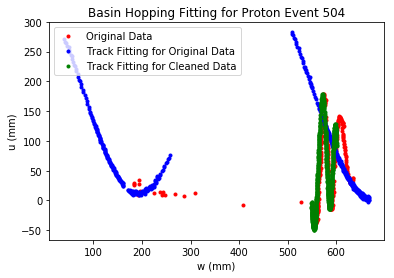

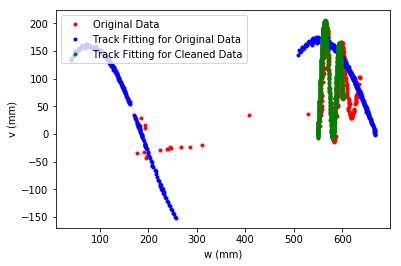

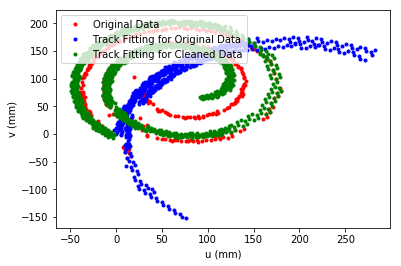

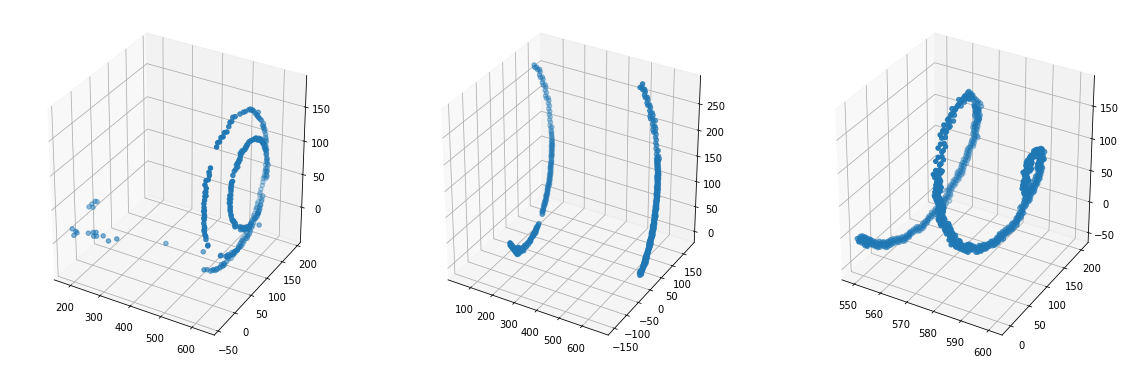

In [58]:
%matplotlib inline
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Original Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Track Fitting for Original Data')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label="Track Fitting for Cleaned Data")
plt.xlabel("w (mm)")
plt.ylabel("u (mm)")
plt.title("Basin Hopping Fitting for Proton Event 504")
plt.legend(loc=2)
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Original Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Track Fitting for Original Data')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label="Track Fitting for Cleaned Data")
plt.xlabel("w (mm)")
plt.ylabel("v (mm)")
plt.legend(loc=2)
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Original Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.', label='Track Fitting for Original Data')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label="Track Fitting for Cleaned Data")
plt.xlabel("u (mm)")
plt.ylabel("v (mm)")
plt.legend(loc=2)
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

In [ ]:
array = np.array([0,1,2,3,4,5])
a = {i for i in array}
print(a)
b = {4}
print(a[2])